In [1]:
pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
import seaborn as sns

# Specific Libraries
import os
import librosa
import librosa.display
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from scipy.signal import butter, filtfilt
from scipy.signal import wiener
from tqdm import tqdm, trange
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation



In [4]:
sounds_df = pd.read_csv('/kaggle/input/urbansound8k/UrbanSound8K.csv')
sounds_df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [5]:
sounds_freq = sounds_df['class'].value_counts().sort_values()
print(sounds_freq)

class
gun_shot             374
car_horn             429
siren                929
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
Name: count, dtype: int64


# 1D CNN Model

In [25]:
def get_cnn_model(input_shape,num_labels):
    model = Sequential()

    model.add(Conv1D(64, kernel_size=3, padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))  

    model.add(Conv1D(128, kernel_size=3, padding='same'))  
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(256, kernel_size=3, padding='same'))  
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    
    return model

model = get_cnn_model((50,1),10)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,178 (2.10 MB)

 Trainable params: 551,178 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

# Low Pass Filter


In [6]:
def butterworth_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butterworth_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

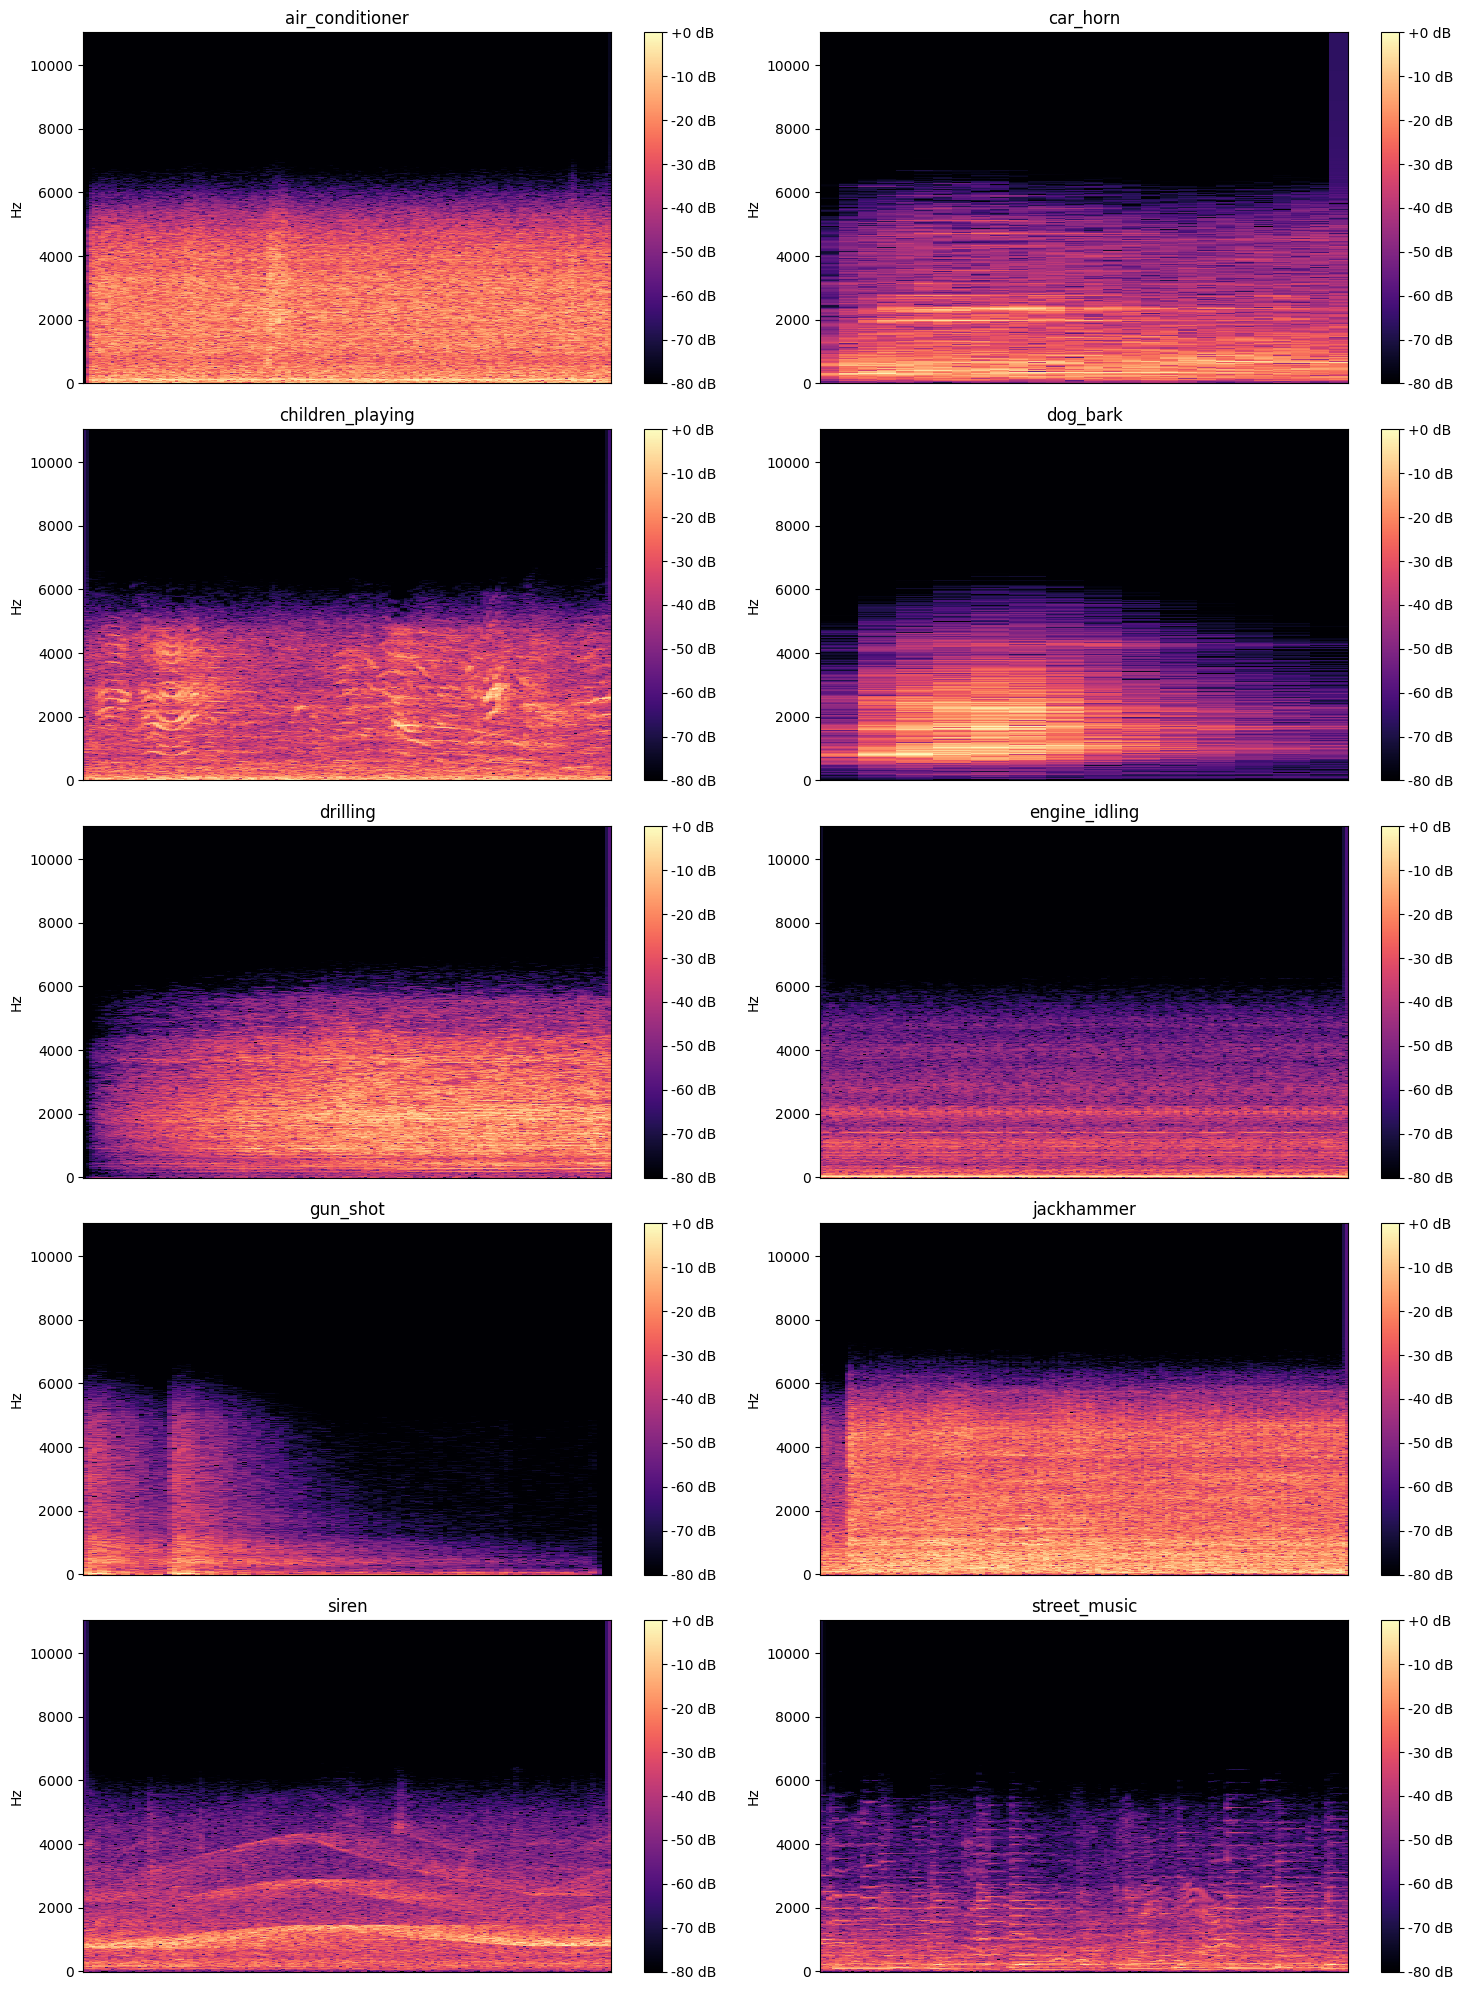

In [7]:
plt.figure(figsize=(15, 20))

for i in range(10):
    wav = sounds_df[(sounds_df['classID'] == i)].iloc[0]['slice_file_name']
    fold = sounds_df[(sounds_df['classID'] == i)].iloc[0]['fold']
    tclass = sounds_df[(sounds_df['classID'] == i)].iloc[0]['class']
    path = f'../input/urbansound8k/fold{fold}/{wav}'
    
    data, sampling_rate = librosa.load(path)
    
    cutoff_frequency = 5000
    filtered_data = lowpass_filter(data, cutoff=cutoff_frequency, fs=sampling_rate)

    D = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_data)), ref=np.max)

    plt.subplot(5, 2, i + 1)
    librosa.display.specshow(D, y_axis='linear', sr=sampling_rate)
    plt.colorbar(format='%+2.0f dB')
    plt.title(tclass)

plt.tight_layout()
plt.show()

In [8]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name)
    filtered_signal = lowpass_filter(sample, cutoff=1000, fs=sample_rate)
    feature = librosa.feature.mfcc(y=filtered_signal,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

extracted = []
path = '/kaggle/input/urbansound8k'

for index_num,row in tqdm(sounds_df.iterrows()):
    file_name = os.path.join(os.path.abspath(path),'fold'+str(row["fold"])+'/',str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data= features_extract(file_name)    
    extracted.append([data,final_class_labels])

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [9]:
lowpass_ext_df = pd.DataFrame(extracted,columns=['feature','class'])
lowpass_ext_df

feature             class
0     [-460.0088702768386, 175.11165514594768, 14.25...          dog_bark
1     [-727.5041238674781, 265.9980787961822, 102.18...  children_playing
2     [-736.9682903991747, 258.325996133109, 102.191...  children_playing
3     [-689.7265590568004, 241.0182438699519, 103.41...  children_playing
4     [-737.0464723260358, 258.54455995864623, 102.5...  children_playing
...                                                 ...               ...
8727  [-701.9822018488626, 293.0753838279886, 100.71...          car_horn
8728  [-688.9898558596011, 285.0059745566503, 98.064...          car_horn
8729  [-568.0871337738002, 240.38430272972292, 93.12...          car_horn
8730  [-629.4595160584396, 268.9316991804481, 94.150...          car_horn
8731  [-634.8020965837819, 272.42592823941453, 102.4...          car_horn

[8732 rows x 2 columns]

In [26]:
lowpass_x = np.array(lowpass_ext_df['feature'].tolist())
lowpass_y = np.array(lowpass_ext_df['class'].tolist())

In [27]:
le = LabelEncoder()
lowpass_y = to_categorical(le.fit_transform(lowpass_y))

In [28]:
x_train, x_test, y_train, y_test = train_test_split(lowpass_x, lowpass_y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [31]:
x_train = x_train.reshape(6985,50,1)
x_train.shape

(6985, 50, 1)

In [46]:
model = get_cnn_model((x_train.shape[1],x_train.shape[2]),10)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=50,
          validation_data=(x_test, y_test),
         )

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1792 - loss: 3.0842 - val_accuracy: 0.3967 - val_loss: 1.7073
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3614 - loss: 1.7124 - val_accuracy: 0.4780 - val_loss: 1.4480
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5087 - loss: 1.3914 - val_accuracy: 0.6193 - val_loss: 1.0934
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6031 - loss: 1.1468 - val_accuracy: 0.6840 - val_loss: 0.9258
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6613 - loss: 0.9921 - val_accuracy: 0.7355 - val_loss: 0.8254
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7343 - loss: 0.8172 - val_accuracy: 0.7762 - val_loss: 0.7101
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7739 - loss: 0.6818 - val_accuracy: 0.7859 - val_loss: 0.6500
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7950 - loss: 0.6427 - val_accu

In [48]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name)
    filtered_signal = lowpass_filter(sample, cutoff=1000, fs=sample_rate)
    feature = librosa.feature.mfcc(y=filtered_signal,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

def print_prediction(file_name):
    pred_fea = feature_extract(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n')

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.93      0.95      0.94       203
        car_horn       0.92      0.91      0.91        86
children_playing       0.81      0.85      0.83       183
        dog_bark       0.86      0.80      0.82       201
        drilling       0.85      0.90      0.87       206
   engine_idling       0.94      0.95      0.95       193
        gun_shot       0.94      0.86      0.90        72
      jackhammer       0.94      0.90      0.92       208
           siren       0.89      0.95      0.92       165
    street_music       0.84      0.80      0.82       230

        accuracy                           0.89      1747
       macro avg       0.89      0.89      0.89      1747
    weighted avg       0.89      0.89      0.89      1747



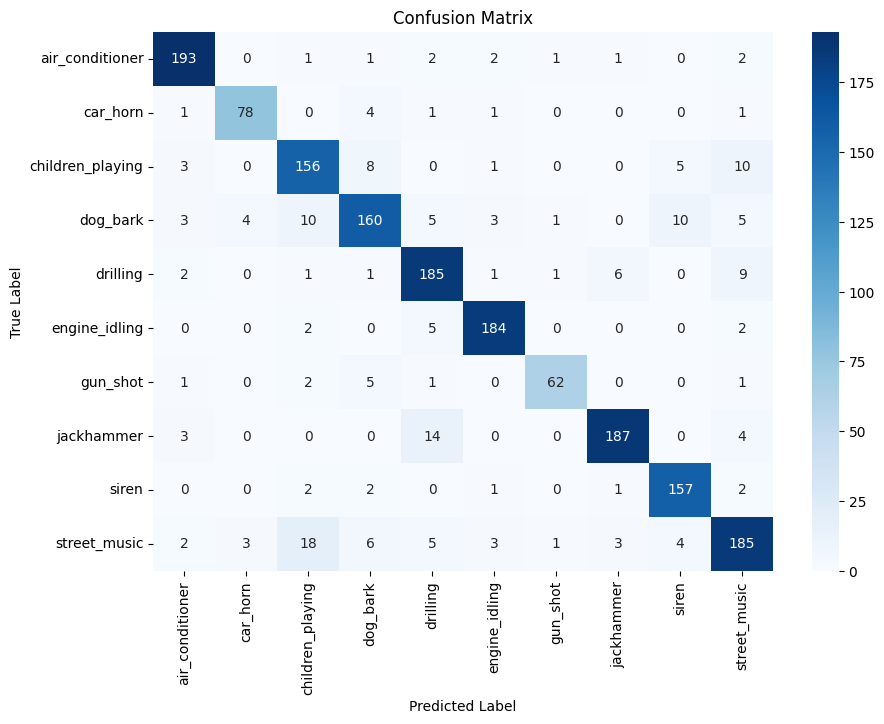

In [49]:
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 
               'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# High Pass Filter

In [10]:
def butterworth_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butterworth_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

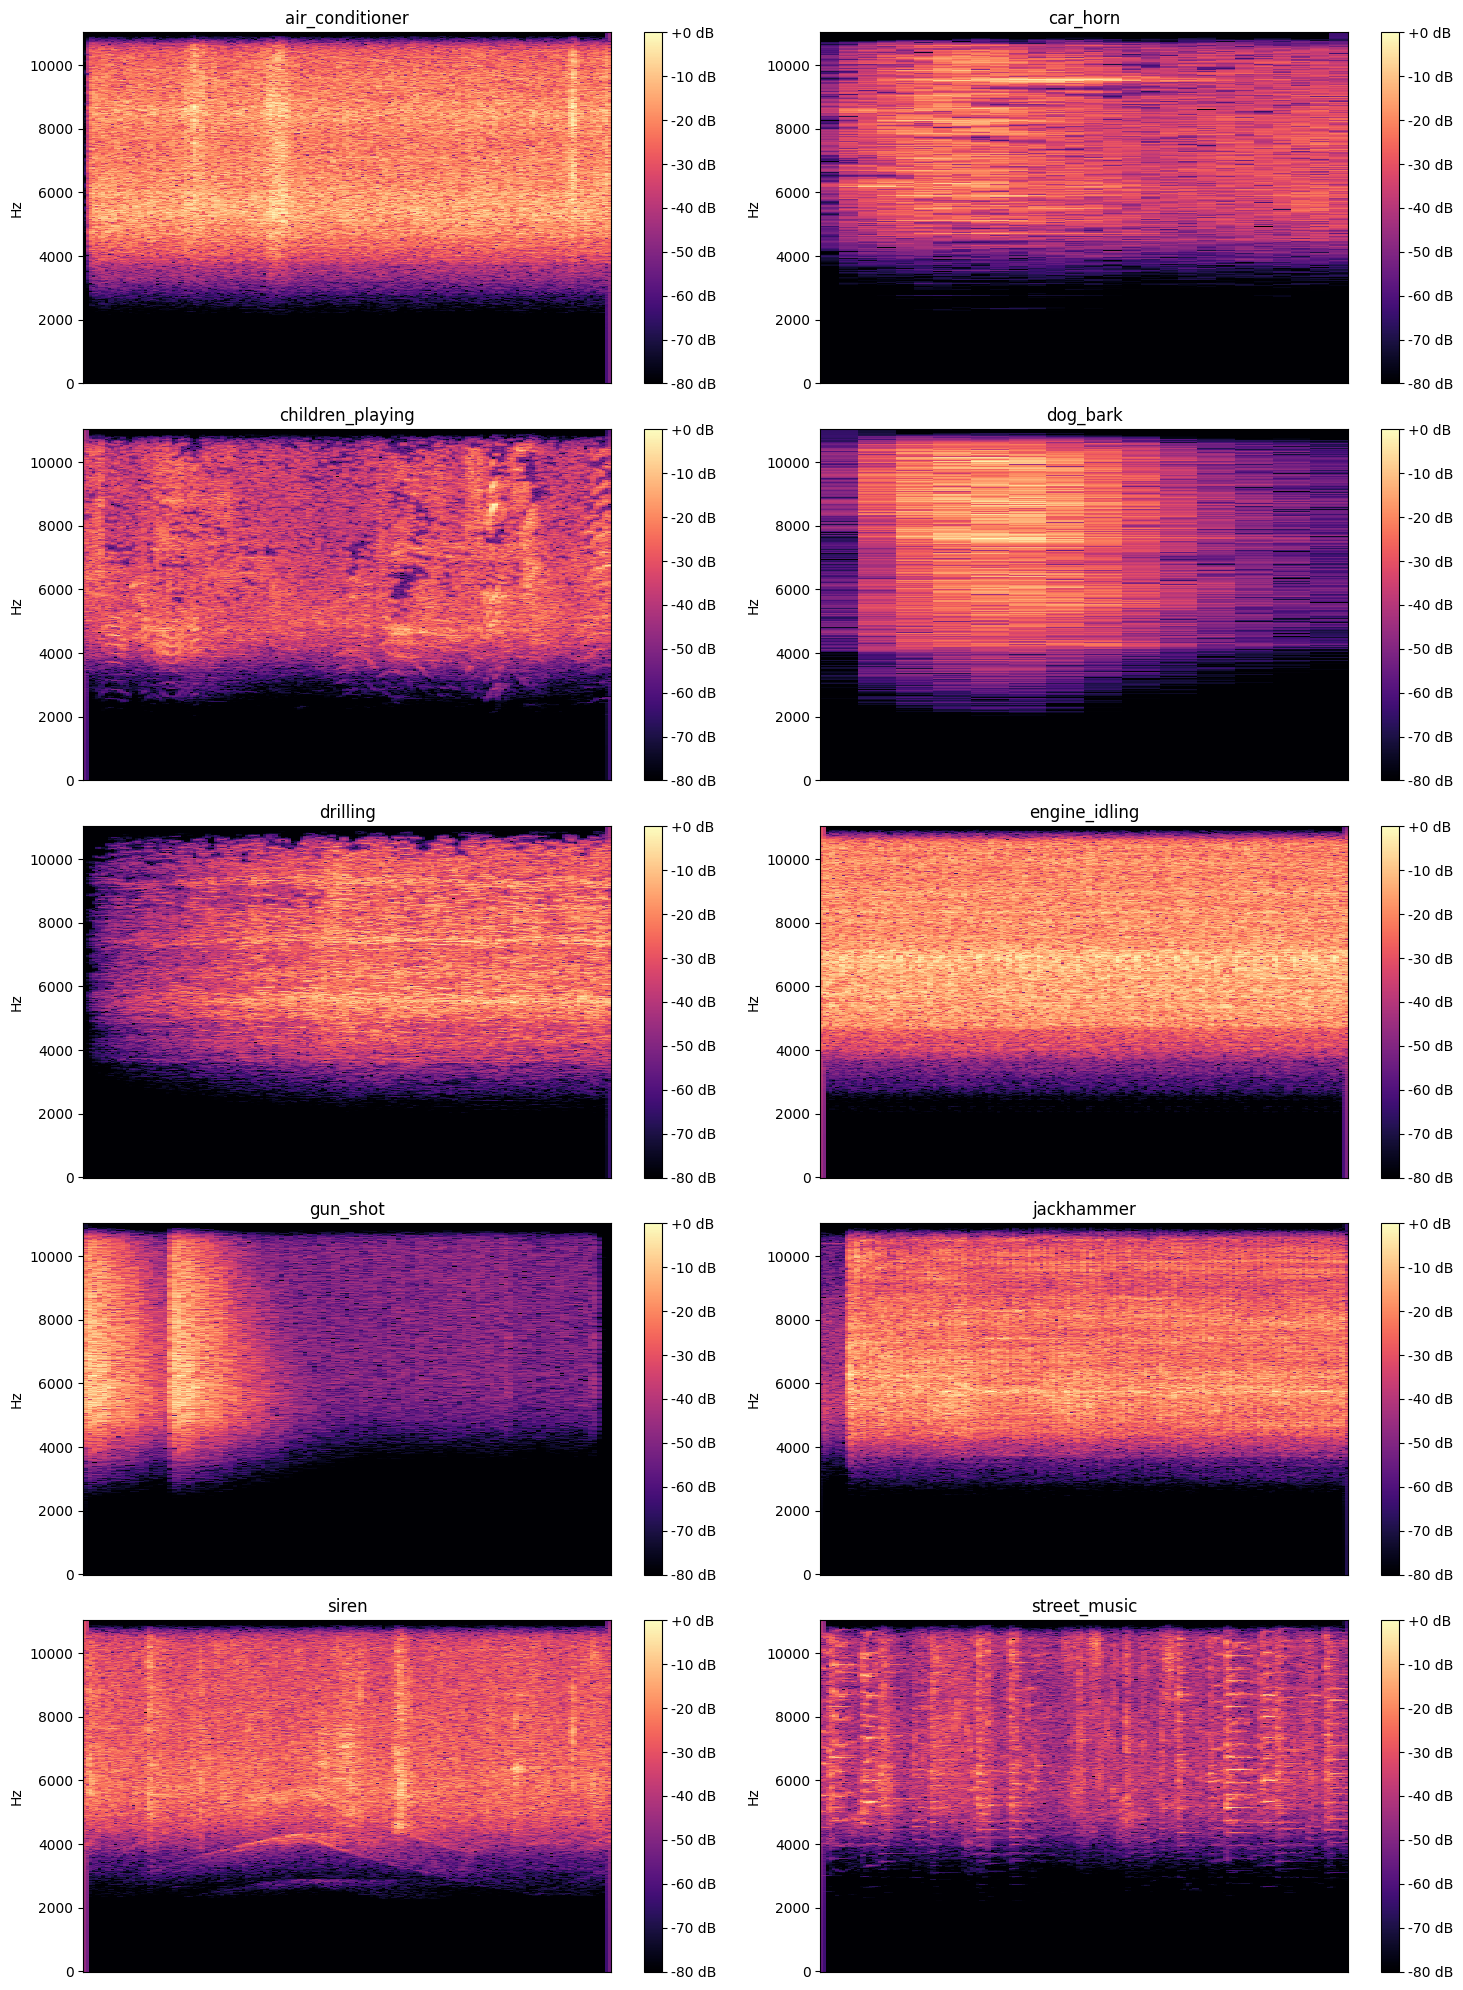

In [11]:
plt.figure(figsize=(15, 20))

for i in range(10):
    wav = sounds_df[(sounds_df['classID'] == i)].iloc[0]['slice_file_name']
    fold = sounds_df[(sounds_df['classID'] == i)].iloc[0]['fold']
    tclass = sounds_df[(sounds_df['classID'] == i)].iloc[0]['class']
    path = f'../input/urbansound8k/fold{fold}/{wav}'
    
    data, sampling_rate = librosa.load(path)
    
    cutoff_frequency = 5000
    filtered_data = highpass_filter(data, cutoff=cutoff_frequency, fs=sampling_rate)

    D = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_data)), ref=np.max)

    plt.subplot(5, 2, i + 1)
    librosa.display.specshow(D, y_axis='linear', sr=sampling_rate)
    plt.colorbar(format='%+2.0f dB')
    plt.title(tclass)

plt.tight_layout()
plt.show()

In [12]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name)
    filtered_signal = highpass_filter(sample, cutoff=1000, fs=sample_rate)
    feature = librosa.feature.mfcc(y=filtered_signal,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

extracted = []
path = '/kaggle/input/urbansound8k'

for index_num,row in tqdm(sounds_df.iterrows()):
    file_name = os.path.join(os.path.abspath(path),'fold'+str(row["fold"])+'/',str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data= features_extract(file_name)    
    extracted.append([data,final_class_labels])

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [13]:
highpass_ext_df = pd.DataFrame(extracted,columns=['feature','class'])
highpass_ext_df

feature             class
0     [-295.5238327537453, -39.136276730394044, -185...          dog_bark
1     [-568.0409392257154, -94.83426568964222, -187....  children_playing
2     [-602.6544105306118, -80.73208102830712, -180....  children_playing
3     [-559.0929876607152, -105.07255990033572, -170...  children_playing
4     [-596.283392031983, -97.84931968691278, -193.6...  children_playing
...                                                 ...               ...
8727  [-549.501595453262, -78.34816476419888, -192.8...          car_horn
8728  [-472.3441646592689, -92.78922958185544, -156....          car_horn
8729  [-449.02446701584824, -92.71372319954584, -180...          car_horn
8730  [-489.0312894016793, -80.10146447928895, -189....          car_horn
8731  [-457.0163171931053, -108.7661560771658, -167....          car_horn

[8732 rows x 2 columns]

In [36]:
highpass_x = np.array(highpass_ext_df['feature'].tolist())
highpass_y = np.array(highpass_ext_df['class'].tolist())

In [37]:
le = LabelEncoder()
highpass_y = to_categorical(le.fit_transform(highpass_y))

In [38]:
x_train, x_test, y_train, y_test = train_test_split(highpass_x, highpass_y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [40]:
x_train = x_train.reshape(6985,50,1)
x_train.shape

(6985, 50, 1)

In [41]:
model = get_cnn_model((x_train.shape[1],x_train.shape[2]),10)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=50,
          validation_data=(x_test, y_test),
         )

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.1807 - loss: 2.9247 - val_accuracy: 0.3194 - val_loss: 1.7896
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3118 - loss: 1.8501 - val_accuracy: 0.4665 - val_loss: 1.5038
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4215 - loss: 1.5582 - val_accuracy: 0.5713 - val_loss: 1.2423
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5285 - loss: 1.3228 - val_accuracy: 0.6182 - val_loss: 1.0870
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6081 - loss: 1.1464 - val_accuracy: 0.6995 - val_loss: 0.9026
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6756 - loss: 0.9448 - val_accuracy: 0.7441 - val_loss: 0.7862
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7175 - loss: 0.8381 - val_accuracy: 0.7722 - val_loss: 0.7078
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7501 - loss: 0.7517 - val_accu

In [43]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name)
    filtered_signal = highpass_filter(sample, cutoff=1000, fs=sample_rate)
    feature = librosa.feature.mfcc(y=filtered_signal,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

def print_prediction(file_name):
    pred_fea = feature_extract(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n')

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.95      0.95      0.95       203
        car_horn       0.97      0.86      0.91        86
children_playing       0.82      0.77      0.79       183
        dog_bark       0.80      0.81      0.80       201
        drilling       0.82      0.88      0.85       206
   engine_idling       0.92      0.95      0.93       193
        gun_shot       0.79      0.85      0.82        72
      jackhammer       0.92      0.94      0.93       208
           siren       0.95      0.90      0.92       165
    street_music       0.82      0.81      0.81       230

        accuracy                           0.87      1747
       macro avg       0.88      0.87      0.87      1747
    weighted avg       0.87      0.87      0.87      1747



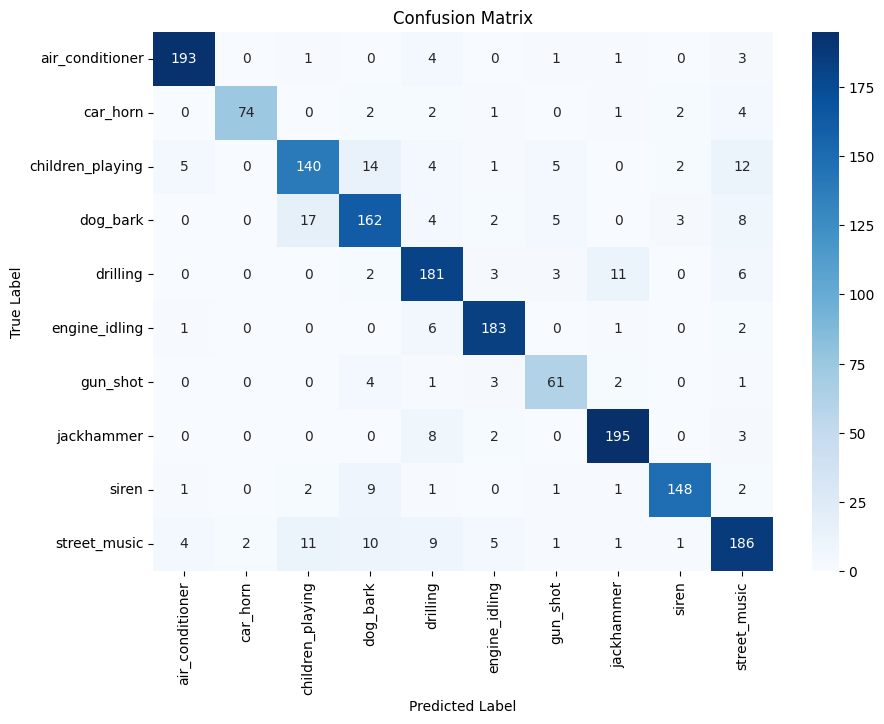

In [44]:
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 
               'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Wiener Filter


In [14]:
def apply_wiener_filter(data, noise=0.1):
    return wiener(data, noise=noise)

/opt/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1647: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/opt/conda/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1647: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


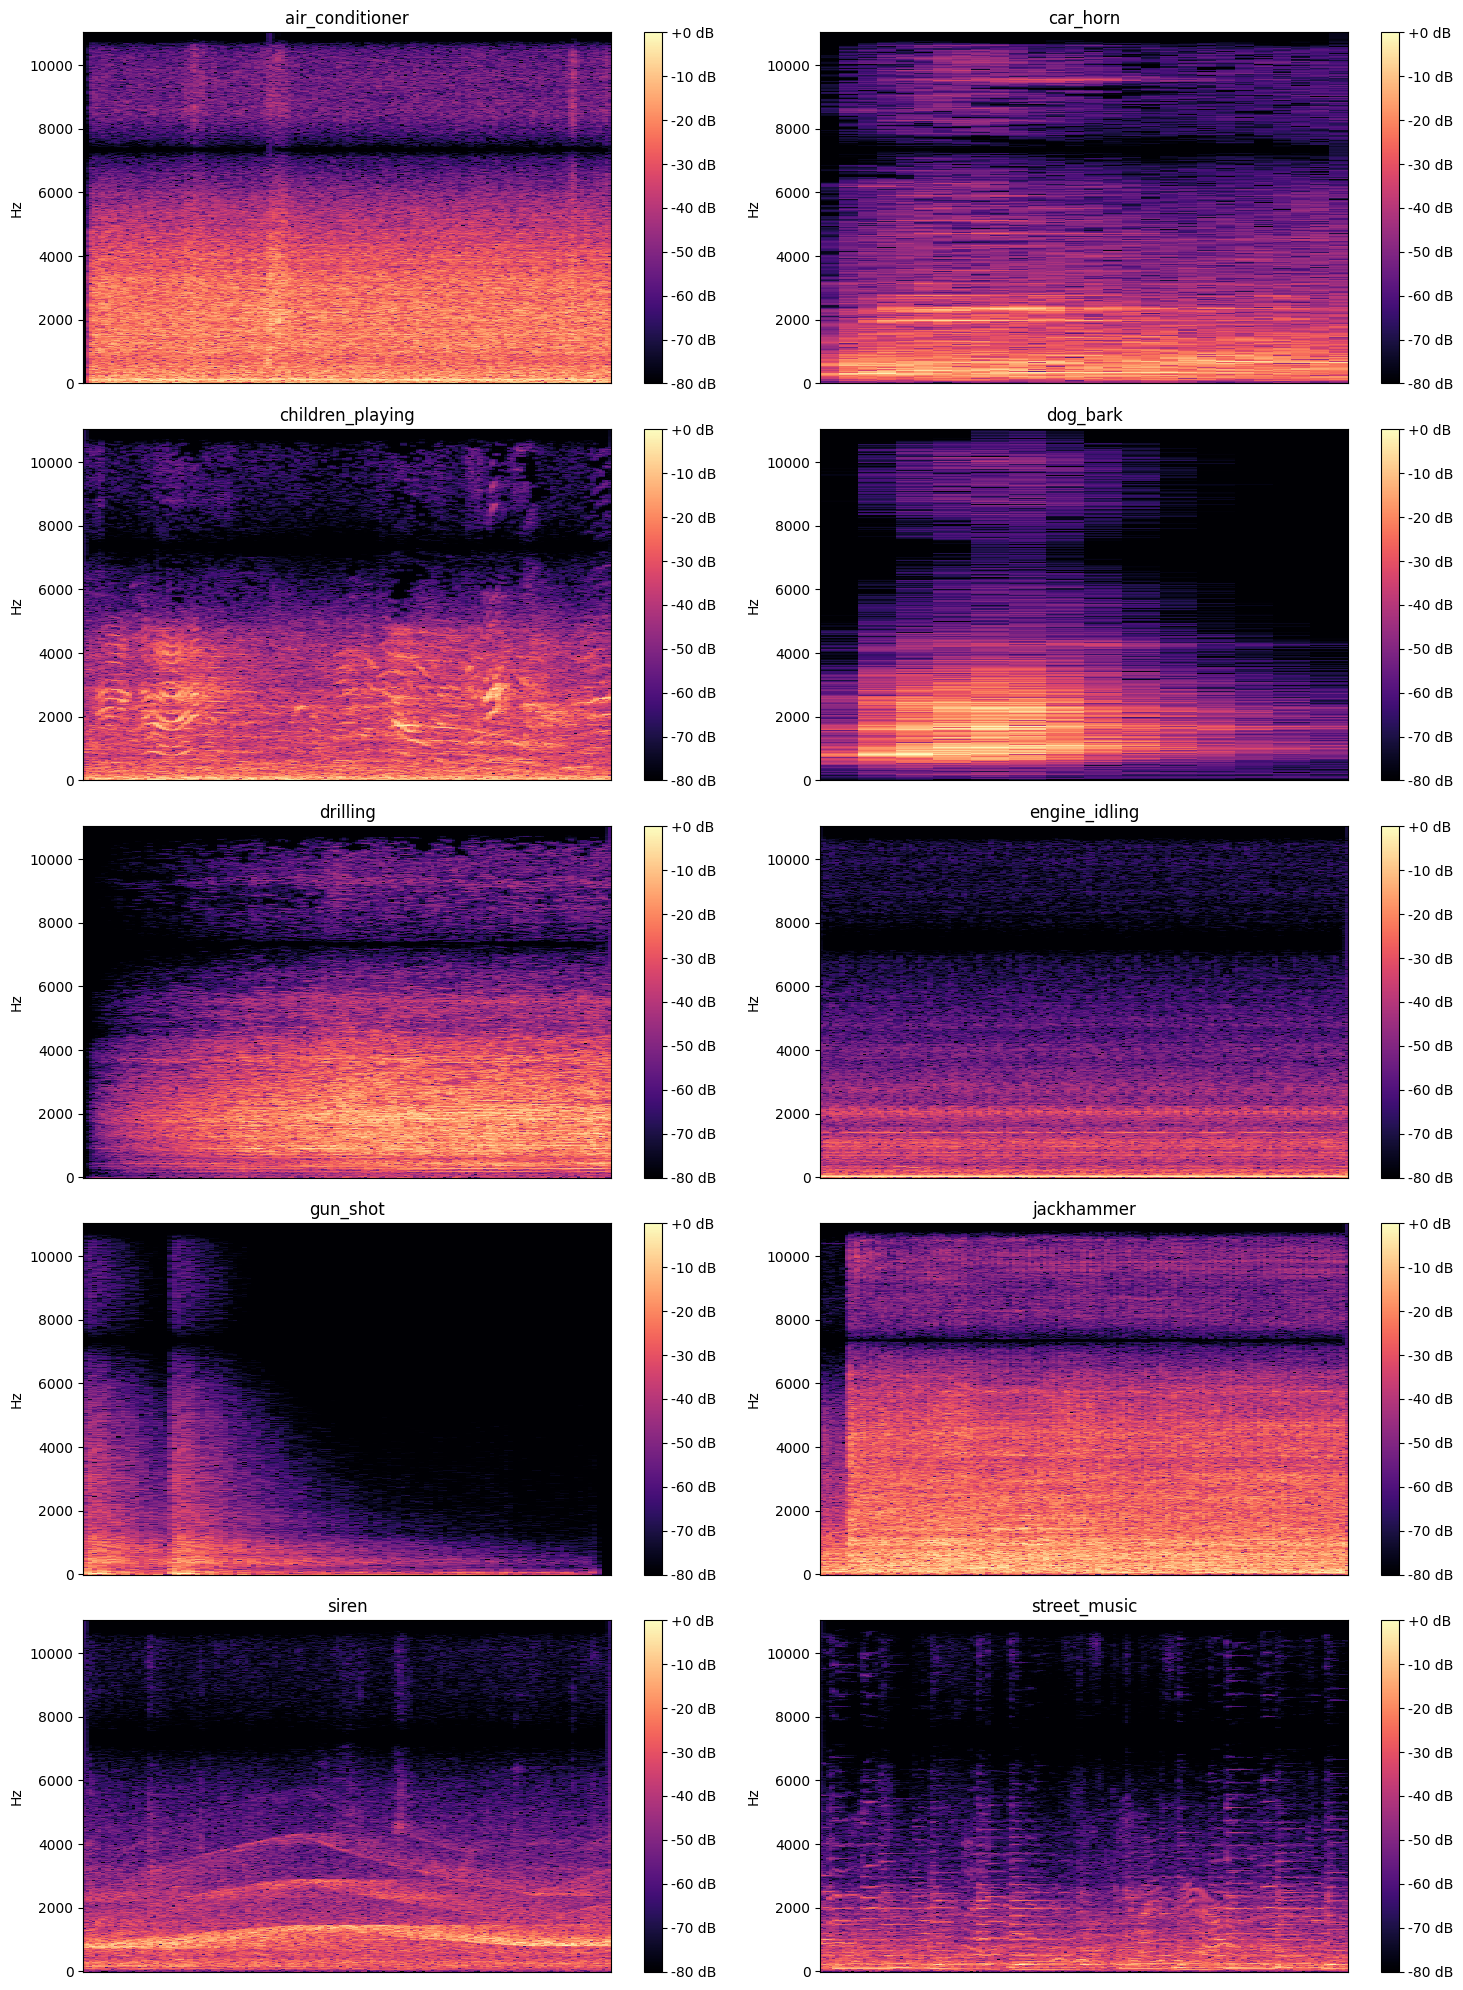

In [18]:
plt.figure(figsize=(15, 20))

for i in range(10):
    wav = sounds_df[(sounds_df['classID'] == i)].iloc[0]['slice_file_name']
    fold = sounds_df[(sounds_df['classID'] == i)].iloc[0]['fold']
    tclass = sounds_df[(sounds_df['classID'] == i)].iloc[0]['class']
    path = f'../input/urbansound8k/fold{fold}/{wav}'
    
    data, sampling_rate = librosa.load(path)
    
    cutoff_frequency = 5000
    filtered_data = apply_wiener_filter(data)

    D = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_data)), ref=np.max)

    plt.subplot(5, 2, i + 1)
    librosa.display.specshow(D, y_axis='linear', sr=sampling_rate)
    plt.colorbar(format='%+2.0f dB')
    plt.title(tclass)

plt.tight_layout()
plt.show()

In [19]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name)
    filtered_signal = apply_wiener_filter(sample)
    feature = librosa.feature.mfcc(y=filtered_signal,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

extracted = []
path = '/kaggle/input/urbansound8k'

for index_num,row in tqdm(sounds_df.iterrows()):
    file_name = os.path.join(os.path.abspath(path),'fold'+str(row["fold"])+'/',str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data= features_extract(file_name)    
    extracted.append([data,final_class_labels])

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [20]:
wiener_ext_df = pd.DataFrame(extracted,columns=['feature','class'])
wiener_ext_df

feature             class
0     [-251.2937131301152, 106.2527939815983, -145.4...          dog_bark
1     [-466.77088101259545, 156.56263904478973, -76....  children_playing
2     [-500.3651087974217, 167.20439673208148, -68.9...  children_playing
3     [-455.92075954028286, 147.99574274349936, -57....  children_playing
4     [-488.6175764591539, 160.0515510257921, -75.12...  children_playing
...                                                 ...               ...
8727  [-439.4827536882099, 180.39652376514127, -72.1...          car_horn
8728  [-388.2682836710191, 132.40211352473506, -67.5...          car_horn
8729  [-344.4424613731509, 155.80373836787606, -67.1...          car_horn
8730  [-385.80568660413707, 171.37104994356315, -77....          car_horn
8731  [-357.6834382333932, 141.19965133873478, -59.5...          car_horn

[8732 rows x 2 columns]

In [50]:
wiener_x = np.array(wiener_ext_df['feature'].tolist())
wiener_y = np.array(wiener_ext_df['class'].tolist())

In [58]:
le = LabelEncoder()
wiener_y = to_categorical(le.fit_transform(wiener_y))

In [59]:
x_train, x_test, y_train, y_test = train_test_split(wiener_x, wiener_y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [60]:
x_train = x_train.reshape(6985,50,1)
x_train.shape

(6985, 50, 1)

In [61]:
model = get_cnn_model((x_train.shape[1],x_train.shape[2]),10)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=50,
          validation_data=(x_test, y_test),
         )

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2078 - loss: 2.6123 - val_accuracy: 0.4906 - val_loss: 1.5833
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4385 - loss: 1.6152 - val_accuracy: 0.6205 - val_loss: 1.1830
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5625 - loss: 1.3062 - val_accuracy: 0.7184 - val_loss: 0.9334
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6376 - loss: 1.0592 - val_accuracy: 0.7659 - val_loss: 0.7714
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7001 - loss: 0.9271 - val_accuracy: 0.8100 - val_loss: 0.6601
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7524 - loss: 0.7596 - val_accuracy: 0.8294 - val_loss: 0.5763
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7853 - loss: 0.6359 - val_accuracy: 0.8392 - val_loss: 0.5270
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8212 - loss: 0.5627 - val_accu

In [63]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name)
    filtered_signal = apply_wiener_filter(sample)
    feature = librosa.feature.mfcc(y=filtered_signal,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

def print_prediction(file_name):
    pred_fea = extract_feature(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n')

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.96      0.96      0.96       203
        car_horn       0.96      0.93      0.95        86
children_playing       0.83      0.87      0.85       183
        dog_bark       0.89      0.88      0.89       201
        drilling       0.87      0.88      0.88       206
   engine_idling       0.94      0.98      0.96       193
        gun_shot       0.93      0.86      0.89        72
      jackhammer       0.98      0.92      0.95       208
           siren       0.97      0.96      0.97       165
    street_music       0.86      0.87      0.87       230

        accuracy                           0.91      1747
       macro avg       0.92      0.91      0.91      1747
    weighted avg       0.91      0.91      0.91      1747



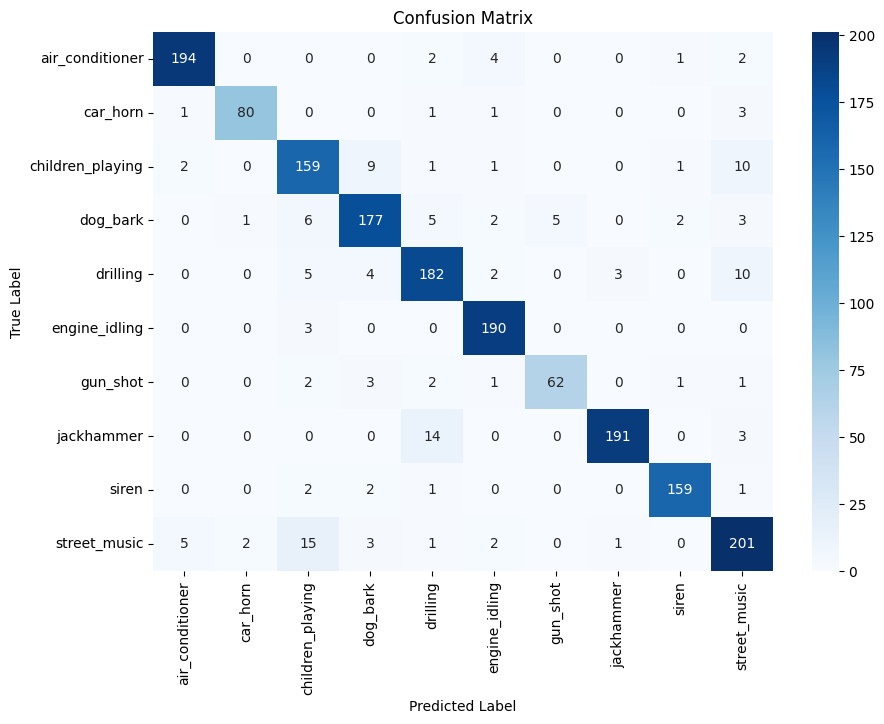

In [64]:
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 
               'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Kalman Filter

In [21]:
def apply_kalman_filter(data, process_variance=1e-5, measurement_variance=0.1):
    n_iter = len(data)
    posteri_estimate = 0.0
    posteri_error_estimate = 1.0
    kalman_filtered = np.zeros(n_iter)

    for i in range(n_iter):
        priori_estimate = posteri_estimate
        priori_error_estimate = posteri_error_estimate + process_variance

        kalman_gain = priori_error_estimate / (priori_error_estimate + measurement_variance)
        posteri_estimate = priori_estimate + kalman_gain * (data[i] - priori_estimate)
        posteri_error_estimate = (1 - kalman_gain) * priori_error_estimate

        kalman_filtered[i] = posteri_estimate

    return kalman_filtered

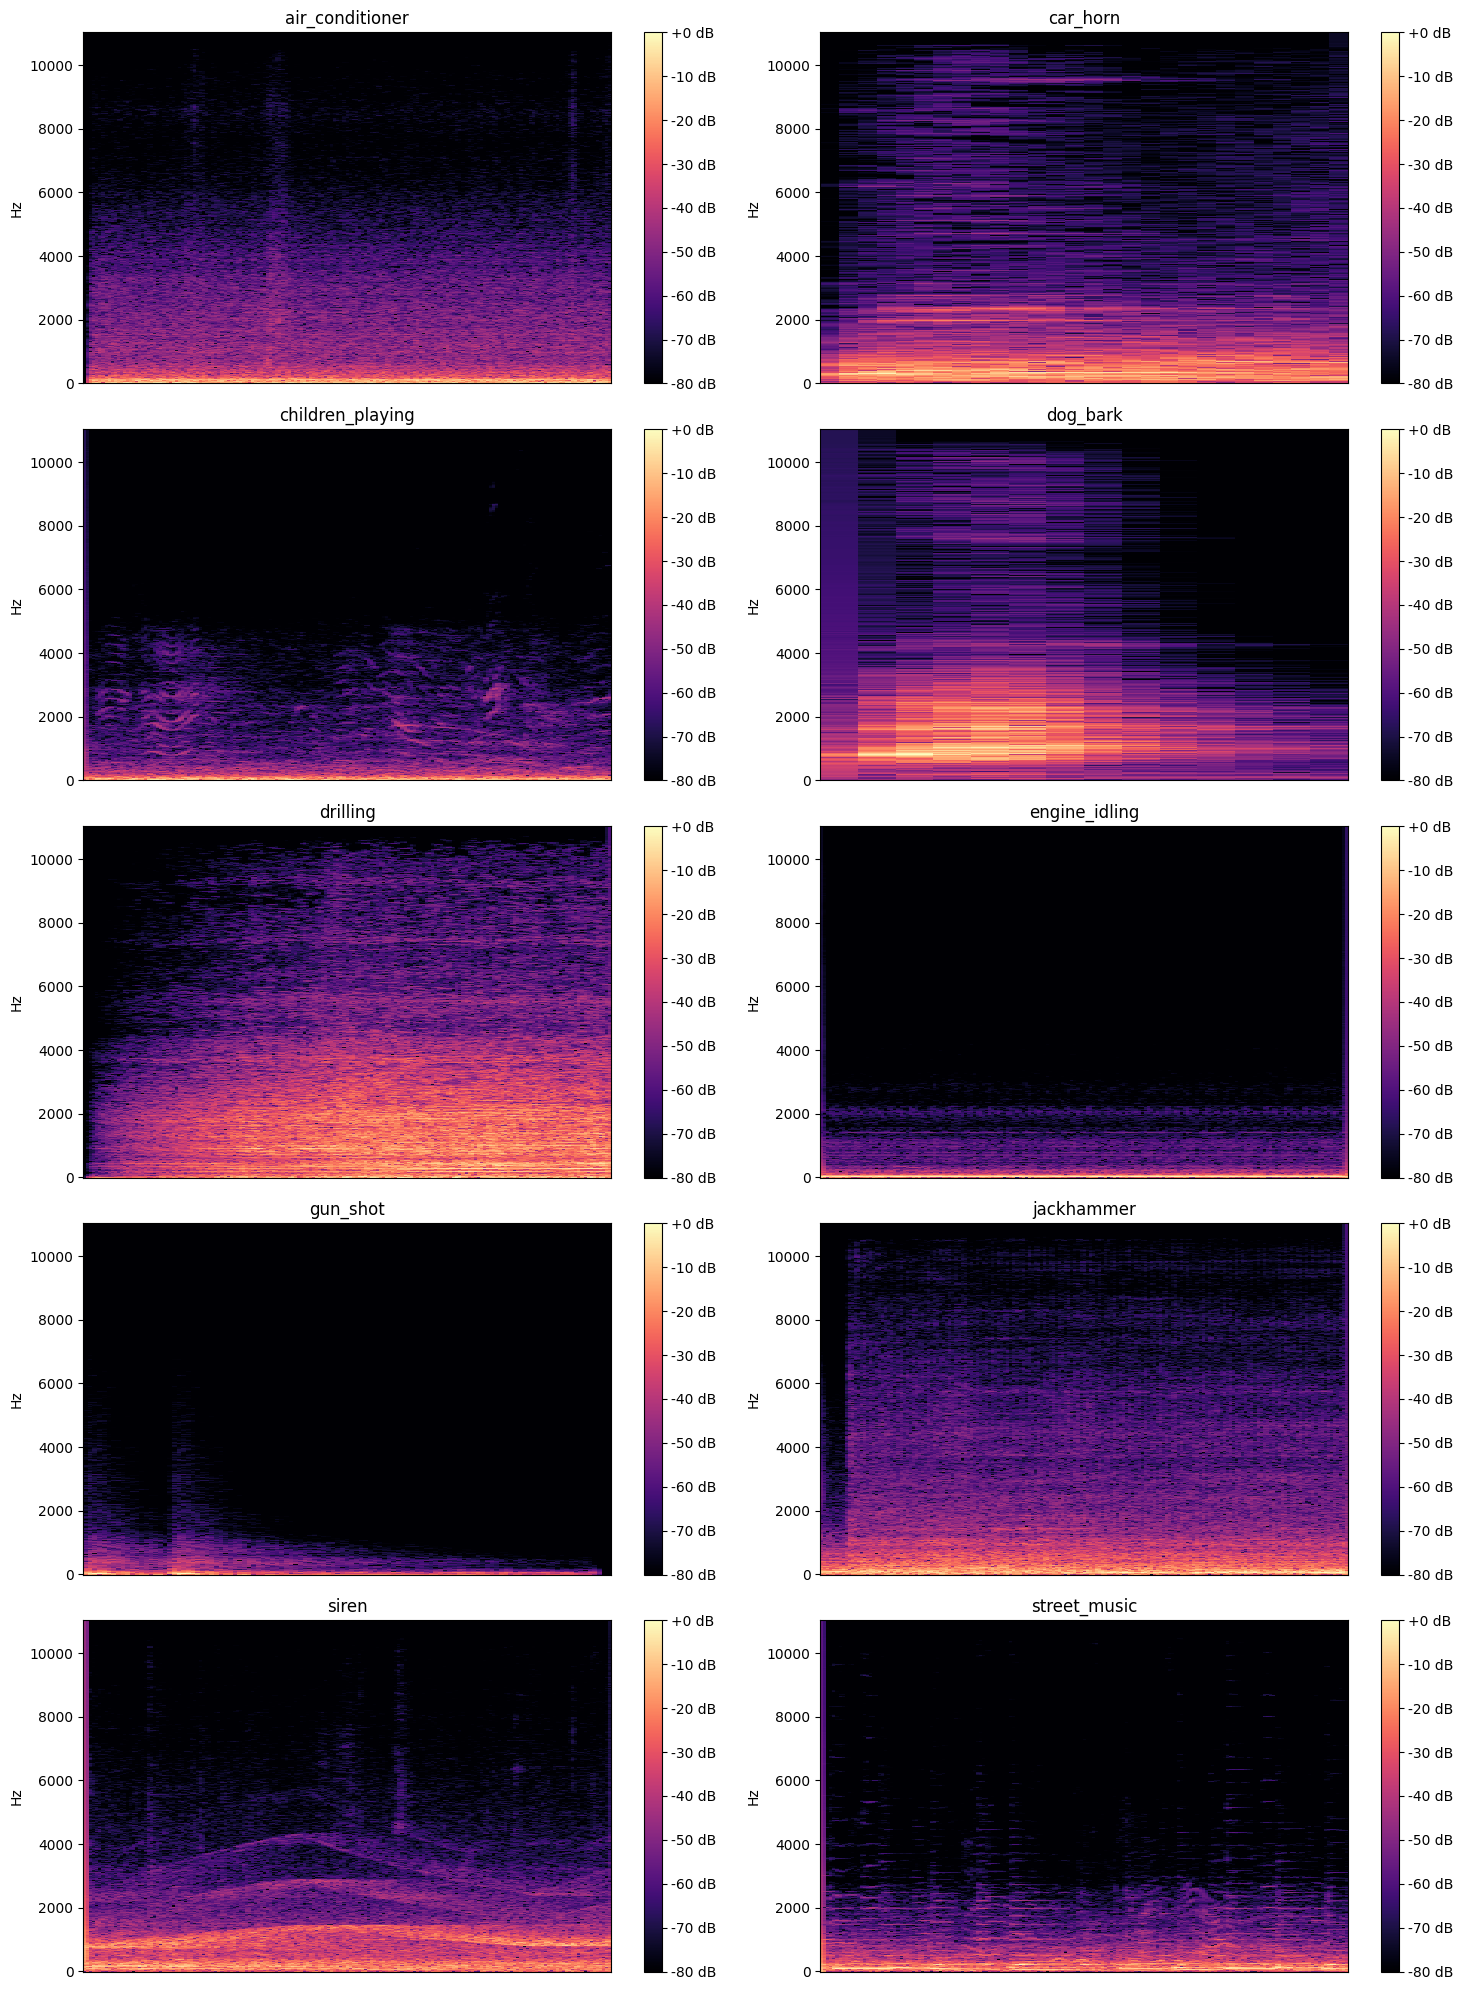

In [22]:
plt.figure(figsize=(15, 20))

for i in range(10):
    wav = sounds_df[(sounds_df['classID'] == i)].iloc[0]['slice_file_name']
    fold = sounds_df[(sounds_df['classID'] == i)].iloc[0]['fold']
    tclass = sounds_df[(sounds_df['classID'] == i)].iloc[0]['class']
    path = f'../input/urbansound8k/fold{fold}/{wav}'
    
    data, sampling_rate = librosa.load(path)
    
    cutoff_frequency = 5000
    filtered_data = apply_kalman_filter(data)

    D = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_data)), ref=np.max)

    plt.subplot(5, 2, i + 1)
    librosa.display.specshow(D, y_axis='linear', sr=sampling_rate)
    plt.colorbar(format='%+2.0f dB')
    plt.title(tclass)

plt.tight_layout()
plt.show()

In [23]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name)
    filtered_signal = apply_kalman_filter(sample)
    feature = librosa.feature.mfcc(y=filtered_signal,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

extracted = []
path = '/kaggle/input/urbansound8k'

for index_num,row in tqdm(sounds_df.iterrows()):
    file_name = os.path.join(os.path.abspath(path),'fold'+str(row["fold"])+'/',str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data= features_extract(file_name)    
    extracted.append([data,final_class_labels])

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [24]:
kalman_ext_df = pd.DataFrame(extracted,columns=['feature','class'])
kalman_ext_df

feature             class
0     [-568.6362300115751, 147.50552246345413, -87.7...          dog_bark
1     [-764.3090533004112, 165.4223060822686, 9.8354...  children_playing
2     [-786.1943146513709, 161.430845887982, 27.4520...  children_playing
3     [-763.0491795538549, 169.99067937751929, 16.56...  children_playing
4     [-782.8840486065429, 164.5339081224633, 14.853...  children_playing
...                                                 ...               ...
8727  [-749.9601723567248, 205.5269385854161, 1.1380...          car_horn
8728  [-709.8900477318832, 173.98078573532203, -9.98...          car_horn
8729  [-667.562174312478, 198.48603593259892, -9.557...          car_horn
8730  [-700.9691071273679, 203.52096462734224, -10.8...          car_horn
8731  [-679.516314220083, 184.19520934348625, -2.802...          car_horn

[8732 rows x 2 columns]

In [65]:
kalman_x = np.array(kalman_ext_df['feature'].tolist())
kalman_y = np.array(kalman_ext_df['class'].tolist())

In [66]:
le = LabelEncoder()
kalman_y = to_categorical(le.fit_transform(kalman_y))

In [67]:
x_train, x_test, y_train, y_test = train_test_split(kalman_x, kalman_y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [68]:
x_train = x_train.reshape(6985,50,1)
x_train.shape

(6985, 50, 1)

In [69]:
model = get_cnn_model((x_train.shape[1],x_train.shape[2]),10)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=50,
          validation_data=(x_test, y_test),
         )

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1736 - loss: 2.2249 - val_accuracy: 0.3749 - val_loss: 1.7956
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3428 - loss: 1.8463 - val_accuracy: 0.5535 - val_loss: 1.4308
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4527 - loss: 1.5461 - val_accuracy: 0.6285 - val_loss: 1.1475
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5503 - loss: 1.3126 - val_accuracy: 0.7115 - val_loss: 0.9233
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6175 - loss: 1.1359 - val_accuracy: 0.7355 - val_loss: 0.8412
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6757 - loss: 0.9832 - val_accuracy: 0.7659 - val_loss: 0.7124
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7260 - loss: 0.8622 - val_accuracy: 0.7842 - val_loss: 0.6862
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7571 - loss: 0.7533 - val_accu

In [72]:
def features_extract(file):
    sample,sample_rate = librosa.load(file_name)
    filtered_signal = apply_kalman_filter(sample)
    feature = librosa.feature.mfcc(y=filtered_signal,sr=sample_rate,n_mfcc=50)
    scaled_feature = np.mean(feature.T,axis=0)
    return scaled_feature

def print_prediction(file_name):
    pred_fea = extract_feature(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n')

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.89      0.93      0.91       203
        car_horn       0.95      0.90      0.92        86
children_playing       0.82      0.70      0.76       183
        dog_bark       0.79      0.86      0.82       201
        drilling       0.94      0.86      0.90       206
   engine_idling       0.89      0.97      0.93       193
        gun_shot       0.92      0.83      0.88        72
      jackhammer       0.97      0.94      0.95       208
           siren       0.93      0.92      0.92       165
    street_music       0.79      0.85      0.82       230

        accuracy                           0.88      1747
       macro avg       0.89      0.88      0.88      1747
    weighted avg       0.88      0.88      0.88      1747



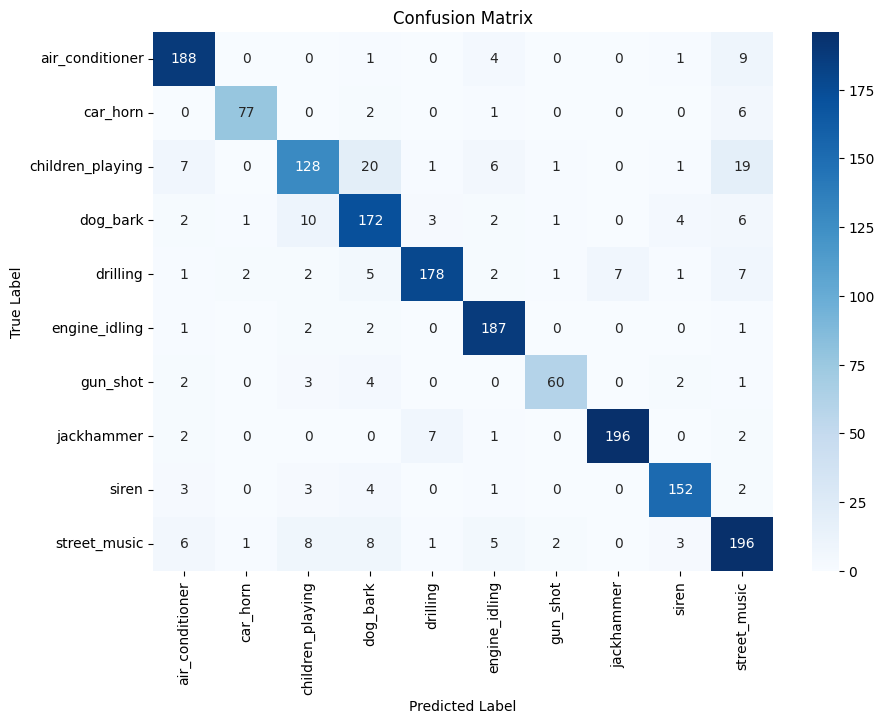

In [73]:
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

class_names = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 
               'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()